In [17]:
import numpy as np
import pandas as pd
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import math

## Visualize the datasets

Plot the dust deposition rate of the empirical dataset in the measurement locations and the simulated data on the global grid.

In [18]:
df_empirical_Holocene = pd.read_csv("df_empirical_Holocene.csv")
df_empirical_LGM = pd.read_csv("df_empirical_LGM.csv")

In [19]:
world_map = gpd.read_file(geodatasets.get_path('naturalearth.land'))

In [20]:
def plot_dust_deposition_map(df, title, name_to_save, label_str='log_dep', measure_units='Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]', limit_bar = 3.2):
    """Generate a map plot of dust deposition based on the provided dataframe.

    Parameters:
    - df (pandas DataFrame): The dataframe containing the dust deposition data.
    - title(str): The title to be displayed on the plot.
    - name_to_save (str): The filename to save the generated map plot.
    - label_str (str, optional): The column name in the dataframe to use for labeling the data on the plot. Defaults to 'log_dep'.
    - measure_units (str, optional): The units of measurement for the dust flux. Defaults to 'Dust flux log$_{10}$[g m$^{-2}$ a$^{-1}$]'.
    - limit_bar (float, optional): The limit value for the colorbar on the plot. Defaults to 3.2."""

    df_dust_geopandas = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

    fig, ax = plt.subplots(figsize=(12, 10))

    # Set limits and ticks
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    ax.set_xticks(np.arange(-180, 181, 45))
    ax.set_yticks(np.arange(-90, 91, 30))

    # Plot world map
    world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)

    # Plot the GeoDataFrame
    df_dust_geopandas.plot(column=label_str,
                           ax=ax,
                           legend=True,
                           legend_kwds={'label': measure_units, 'orientation': "horizontal"},
                           cmap='viridis',
                           vmin=-limit_bar,
                           vmax=limit_bar,
                           linewidth=0.005,
                           markersize=100)

    # Set labels and title
    ax.set(xlabel='Longitude', ylabel='Latitude', title=title)

    # Save and show the plot
    plt.savefig(f"{name_to_save}.pdf", bbox_inches='tight', dpi=600)
    plt.show()

    return


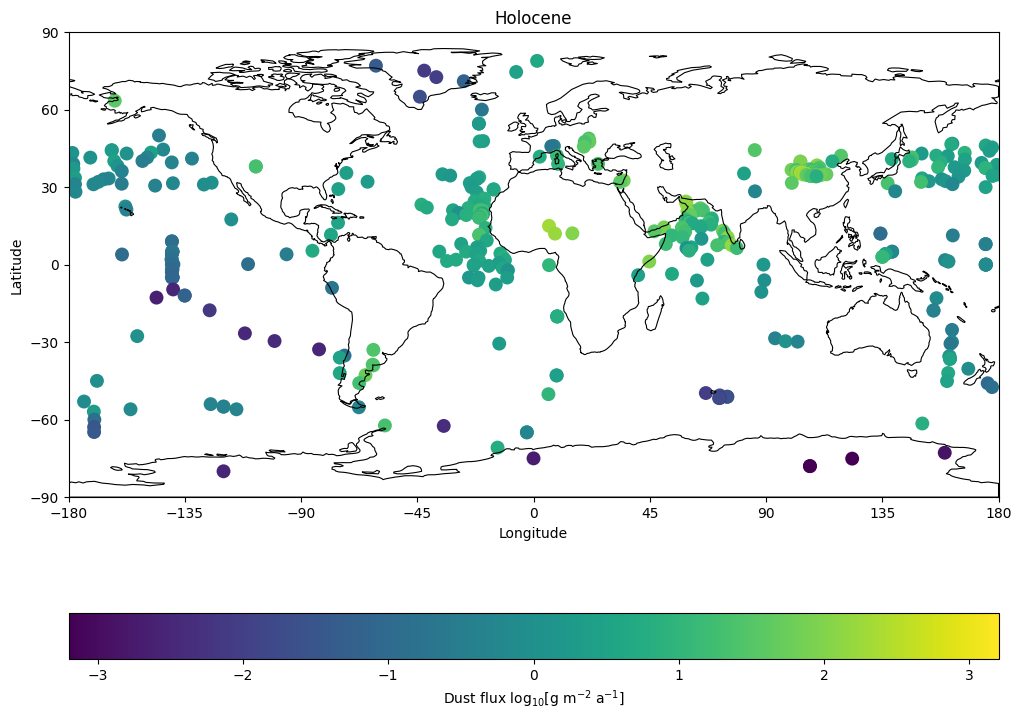

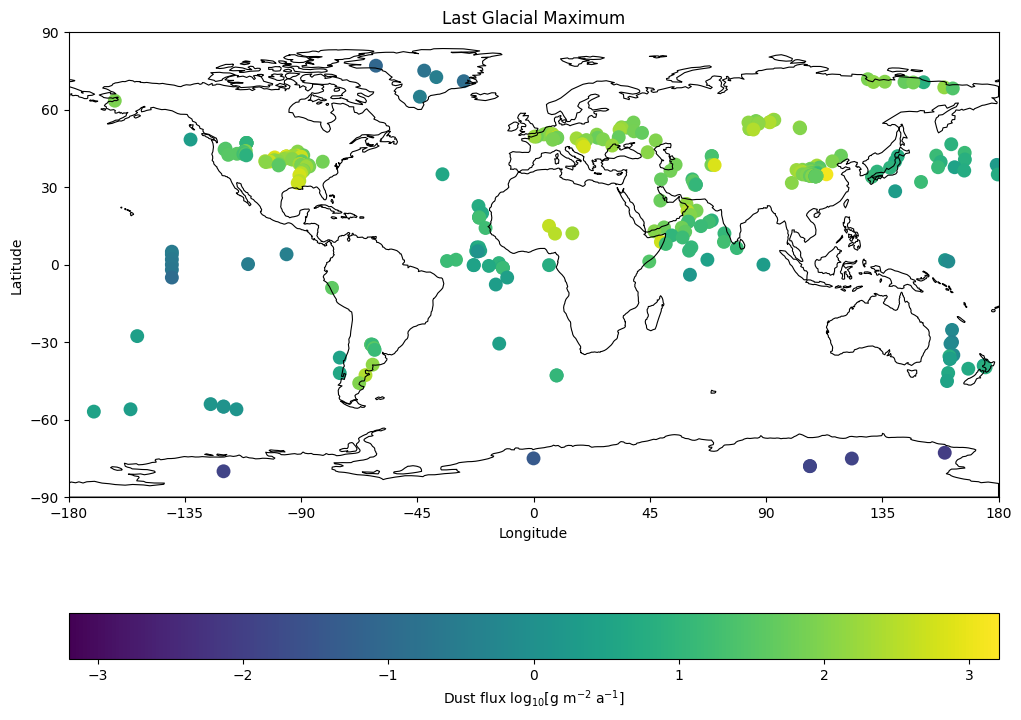

In [21]:
plot_dust_deposition_map(df=df_empirical_Holocene,
                         title='Holocene',
                         name_to_save='DATA_MAP_HOLOCENE')

plot_dust_deposition_map(df=df_empirical_LGM,
                         title='Last Glacial Maximum',
                         name_to_save='DATA_MAP_LGM')

## Create and visualize the global grid

The global grid for the predictions consists of 3-degree spacing.

In [22]:
longitude_to_predict = np.linspace(-180, 180, 121)
latitude_to_predict = np.linspace(-90, 90, 61)

xx, yy = np.meshgrid(longitude_to_predict, latitude_to_predict)
XYpairs = np.vstack([ xx.reshape(-1), yy.reshape(-1) ])
df_gpd_global_grid = gpd.GeoDataFrame(geometry=gpd.points_from_xy(XYpairs[0], XYpairs[1]))
df_global_grid = pd.DataFrame({
    'lon': df_gpd_global_grid.geometry.x,
    'lat': df_gpd_global_grid.geometry.y
})

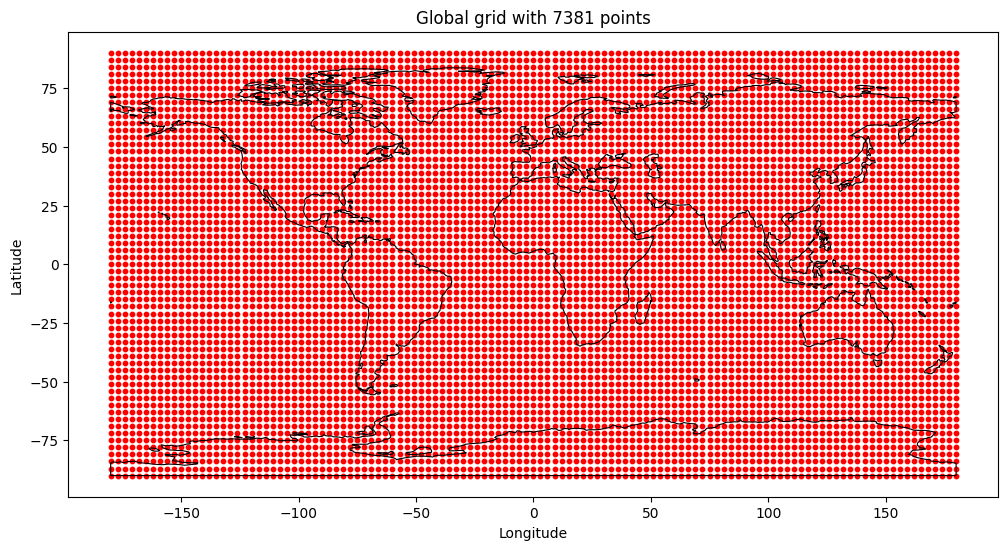

In [23]:
fig, ax = plt.subplots(figsize=(12,10))
world_map.boundary.plot(ax=ax, color='black', linewidth=0.8)
df_gpd_global_grid.plot(ax=ax, color='red', markersize=10, marker ='o')

ax.set(xlabel='Longitude', ylabel='Latitude',
       title=f'Global grid with {df_gpd_global_grid.shape[0]} points')
plt.show()

## Analyse global deposition rate with nearest neighbours

The dust deposition rate will be estimated by averaging the values of the $k$ nearest neigbours.

In [24]:
def distance_euclidean(x, y):
    """
    Calculate the Euclidean distance between two points.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    distance = np.sqrt( (x[0] - y[0])**2 + (x[1] - y[1])**2)
    return distance

In [25]:
def distance_geodesic(x, y):
    """
    Calculate the geodesic distance between two points on Earth.

    Parameters:
    x,y : Iterable
        Vectors for the 2D location of the two points.
    """
    lat1 = math.radians(x[0])
    lon1 = math.radians(x[1])
    lat2 = math.radians(y[0])
    lon2 = math.radians(y[1])
    radio_tierra = 6371 #km

    distancia = radio_tierra * math.acos(math.sin(lat1) * math.sin(lat2) + math.cos(lat1) * math.cos(lat2) * math.cos(lon2 - lon1))
    return distancia

In [26]:
def nearest_neighbour_estimation(df, x, k, dist):
    """
    Perform a k nearest neighbour estimation.

    Parameters:
    df : pandas.DataFrame
        The database.
    x : Iterable
        Location for the estimation.
    k : int
        The number of neighbours to consider.
    dist : str
        The type of distance definition.
    """
    
    if dist == "geodesic":
        distance_fun = distance_geodesic
    else:
        distance_fun = distance_euclidean
    
    distances = np.repeat(np.inf, len(df))
    for index, row in df.iterrows():
        distances[index] = distance_fun(x, (row["lon"], row["lat"]))
    
    sorted_indices = np.argsort(distances)
    nearest_points = sorted_indices[:k]
    
    values_neighbours = df.loc[nearest_points, "log_dep"]
    estimation = np.average(values_neighbours)
    
    return estimation

In [27]:
# Choose the number of neighbours to include in the estimation
n_neighbours = 5

In [28]:
df_global_grid_euclidean = df_global_grid
estimations_holocene_euclidean = np.repeat(np.inf, len(df_global_grid_euclidean))
estimations_lgm_euclidean = np.repeat(np.inf, len(df_global_grid_euclidean))

for index, row in df_global_grid_euclidean.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_euclidean[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm_euclidean[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')

df_global_grid_euclidean["est_hol"] = estimations_holocene_euclidean
df_global_grid_euclidean["est_lgm"] = estimations_lgm_euclidean

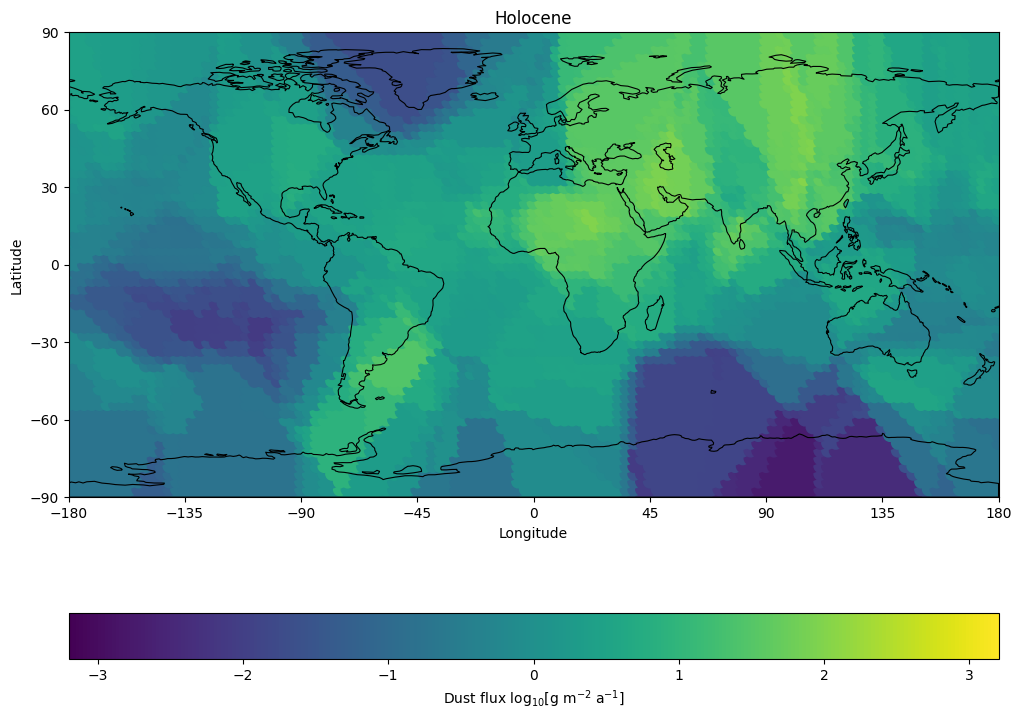

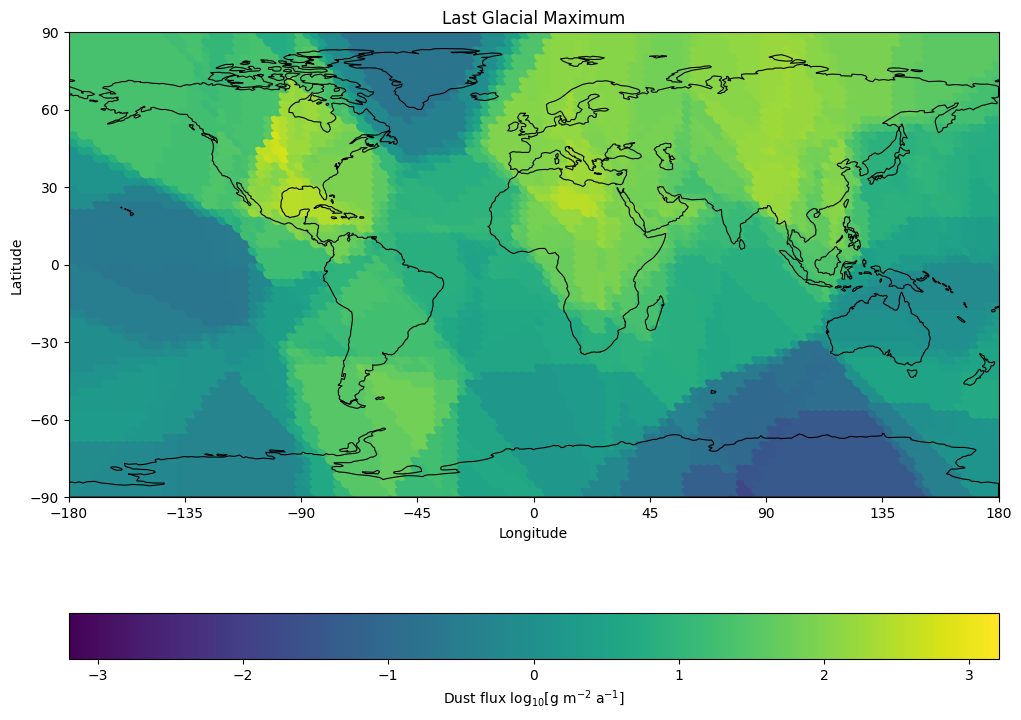

In [29]:
plot_dust_deposition_map(df=df_global_grid_euclidean,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE_EUCLIDEAN',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid_euclidean,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM_EUCLIDEAN',
                         label_str='est_lgm')

In [30]:
df_global_grid_geodesic = df_global_grid
estimations_holocene_geodesic = np.repeat(np.inf, len(df_global_grid_geodesic))
estimations_lgm_geodesic = np.repeat(np.inf, len(df_global_grid_geodesic))

for index, row in df_global_grid_geodesic.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_geodesic[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm_geodesic[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

df_global_grid_geodesic["est_hol"] = estimations_holocene_geodesic
df_global_grid_geodesic["est_lgm"] = estimations_lgm_geodesic

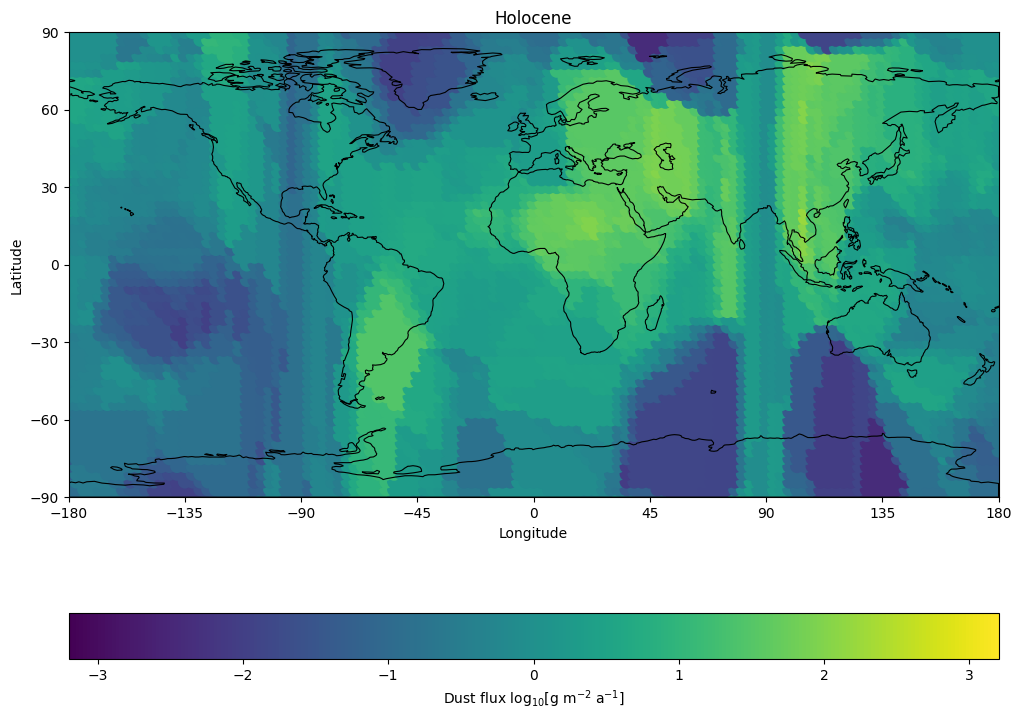

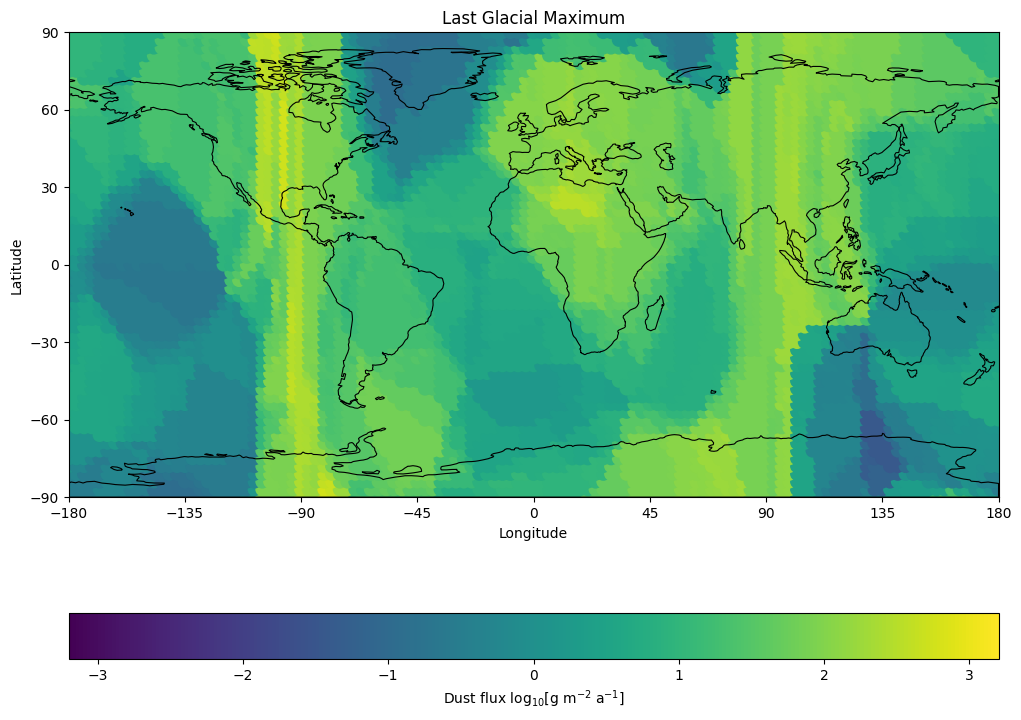

In [31]:
plot_dust_deposition_map(df=df_global_grid_geodesic,
                         title='Holocene',
                         name_to_save='ESTIMATION_MAP_HOLOCENE_GEODESIC',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid_geodesic,
                         title='Last Glacial Maximum',
                         name_to_save='ESTIMATION_MAP_LGM_GEODESIC',
                         label_str='est_lgm')

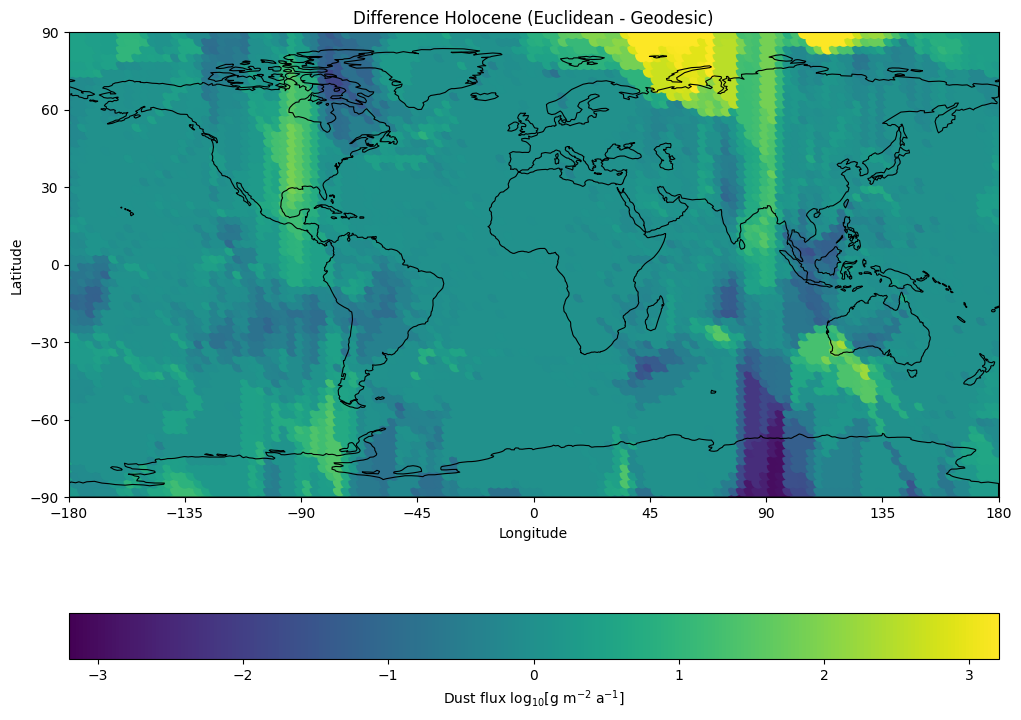

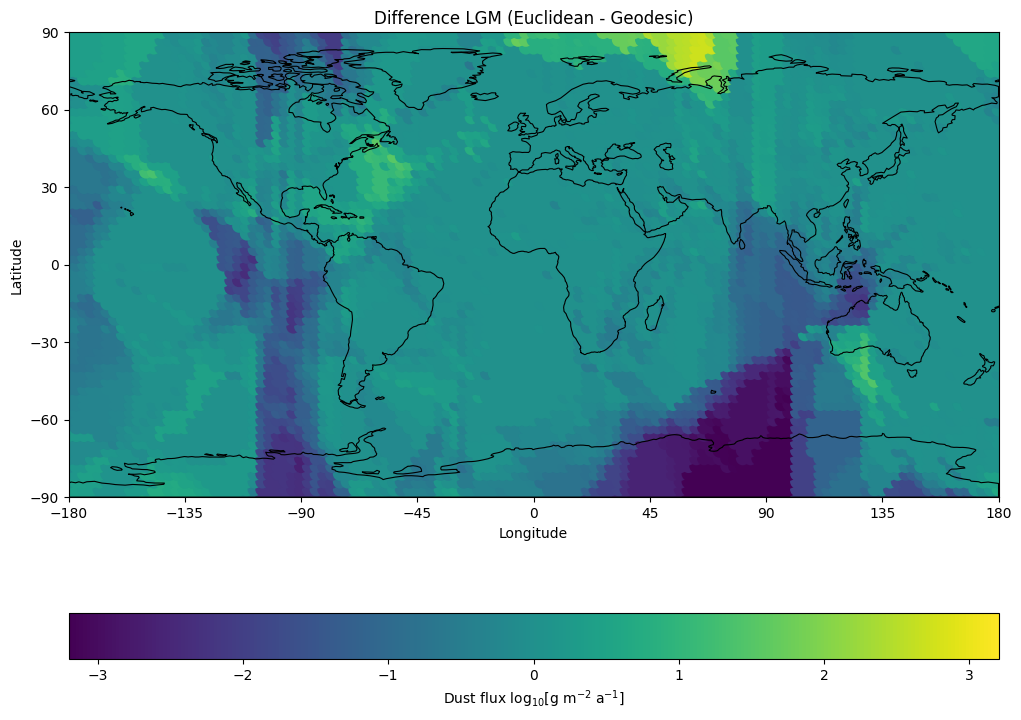

In [39]:
# Calcula la diferencia entre las estimaciones obtenidas con la distancia euclidiana y la distancia geodésica
diferencia_holocene = estimations_holocene_euclidean - estimations_holocene_geodesic
diferencia_lgm = estimations_lgm_euclidean - estimations_lgm_geodesic

df_global_grid["est_hol"] = diferencia_holocene
df_global_grid["est_lgm"] = diferencia_lgm

# Visualiza esta diferencia en un mapa
plot_dust_deposition_map(df=df_global_grid,
                         title='Difference Holocene (Euclidean - Geodesic)',
                         name_to_save='DIFFERENCE_MAP_HOLOCENE',
                         label_str='est_hol')

plot_dust_deposition_map(df=df_global_grid,
                         title='Difference LGM (Euclidean - Geodesic)',
                         name_to_save='DIFFERENCE_MAP_LGM',
                         label_str='est_lgm')


a) **¿Por qué las diferencias son más grandes en una parte que otra parte del mundo?**

   Esto puede deberse a la climatologia de la zona o mas bien por su geografia, ya que si comparamos la distancia euclidiana con la geodesica obtendremos que es mas precisa la geodesica al momento de tener en cuenta la curvatura de la tierra o los desniveles que podrian haber entre un punto y otro, a comparacion de la distancia euclidiana que solo nos da la distancia entre los puntos. Por la parte de la climatologia de la zona, esta puede hacer que varie la distribucion del polvo en dicha zona o verse influenciada la distribucion del polvo por fenomenos climaticos locales.

b) **¿Cuál método es más fidedigno en los polos sur y norte?**

   Si nos fijamos en los graficos anteriores podemos observar que el metodo mas fidedigno para ver la variabilidad del polvo es la distancia geodesica, ya que como hemos mencionado en a) esta tiene en cuenta la curvatura de la tierra y para este caso en particular debiese ser mas preciso el calculo con este metodo por temas fisicos.

c) **¿Cuál método es más fidedigno en longitud 180°?**

   En la longitud 180°, como podemos observar en los graficos la diferencia no es tanta entre un metodo u otro, por lo que podriamos usar cualquiera de los 2, esto puede deberse a que la geografia de esa longitud sea mas plana, de todos modos, como se habla de distancias en la tierra lo mejor seria utilizar la distancia geodesica.

d) **¿Cuáles son las diferencias entre los resultados para el Holoceno y el LGM?**

   Las diferencias entre los resultados para el Holoceno y el LGM pueden deberse a cambios en la deposición de polvo a lo largo del tiempo debido a variaciones en el clima, la vegetación y otros factores ambientales. Por ejemplo, durante el LGM, se esperaría una mayor cobertura de hielo y cambios en la circulación atmosférica que podrían influir en la distribución del polvo en comparación con el Holoceno.

e) **¿Cómo elegir el número de vecinos cercanos?**

   El número de vecinos cercanos a considerar en el método de vecinos cercanos depende de la variabilidad de los datos y la escala espacial de interés. Un número más pequeño de vecinos puede capturar mejor las variaciones locales, mientras que un número mayor puede suavizar las estimaciones y proporcionar una visión más generalizada de los patrones espaciales. La elección del número de vecinos debe basarse en el equilibrio entre la precisión deseada y la capacidad de generalización de los resultados. Es importante probar diferentes valores y evaluar cómo afectan las estimaciones antes de tomar una decisión final.


In [ ]:
# Para la parte de calcular la diferencia entre la distancia euclidiana y la geodesica utilice chat gpt para poder guiarme, el siguiente codigo fue del que me inspire para poder hacer dicha parte
"""
# Calcula las estimaciones utilizando la distancia euclidiana y la distancia geodésica
estimations_holocene_euclidiana = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_euclidiana = np.repeat(np.inf, len(df_global_grid))
estimations_holocene_geodesica = np.repeat(np.inf, len(df_global_grid))
estimations_lgm_geodesica = np.repeat(np.inf, len(df_global_grid))

for index, row in df_global_grid.iterrows():
    point_for_estimation = (row["lon"], row["lat"])
    estimations_holocene_euclidiana[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_lgm_euclidiana[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='euclidean')
    estimations_holocene_geodesica[index] = nearest_neighbour_estimation(df_empirical_Holocene, point_for_estimation, n_neighbours, dist='geodesic')
    estimations_lgm_geodesica[index] = nearest_neighbour_estimation(df_empirical_LGM, point_for_estimation, n_neighbours, dist='geodesic')

# Calcula la diferencia entre las estimaciones obtenidas con la distancia euclidiana y la distancia geodésica
diferencia_holocene = estimations_holocene_euclidiana - estimations_holocene_geodesica
diferencia_lgm = estimations_lgm_euclidiana - estimations_lgm_geodesica

# Visualiza esta diferencia en un mapa
plot_dust_deposition_map(df=df_global_grid,
                         title='Difference Holocene (Euclidean - Geodesic)',
                         name_to_save='DIFFERENCE_MAP_HOLOCENE',
                         label_str='diferencia_holocene')

plot_dust_deposition_map(df=df_global_grid,
                         title='Difference LGM (Euclidean - Geodesic)',
                         name_to_save='DIFFERENCE_MAP_LGM',
                         label_str='diferencia_lgm')
"""
